<a href="https://colab.research.google.com/github/Clalva02/TFG/blob/main/Copia_de_TFM_NN1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Description

This codes creates a CNN1d Inception for evaluating the neck classification events. 


# Imports

In [80]:
import os
import math
from math import sqrt
import sys
import numpy as np
import random
import scipy.stats
from pylab import *
import pickle
import matplotlib.pyplot as plt
from matplotlib.ticker import MaxNLocator
from time import time

from keras.models import Sequential , model_from_json, load_model
import tensorflow as tf
#from keras.utils import multi_gpu_model
from tensorflow.python.keras.layers import Dense, Lambda, Dropout,Convolution1D, MaxPooling1D,AveragePooling1D, Flatten
from tensorflow.python.keras.layers import BatchNormalization, Activation, ZeroPadding1D, ReLU, add, concatenate
from tensorflow.python.keras import Sequential, Input, Model
from tensorflow import keras

from sklearn.metrics import classification_report, roc_curve, auc, mean_squared_error, mean_absolute_error, precision_recall_curve

import pandas as pd

## Libraries for equal formating plots

In [81]:
import matplotlib as mpl# define model

mpl.rcParams['xtick.labelsize'] = 'large'
mpl.rcParams['ytick.labelsize'] = 'large'
mpl.rcParams['axes.labelsize'] = 'large'
mpl.rcParams['axes.titlesize'] = 'large'
mpl.rcParams['legend.fontsize'] = 'large'
mpl.rcParams['font.size'] = '12'
np.set_printoptions(threshold=np.inf)

## Libraries for importing data

In [82]:
# Code to read csv file into colaboratory:
!pip install -U -q PyDrive
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials

In [83]:
auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)

Libraries for statistical test

In [84]:
from scipy.stats import *

# Get data

In [85]:
# Para leer ficheros de datos simulados
def opentimefile(namefile):
	tim0=time()
	data = pd.read_csv(namefile, sep="\t", header=None)
	timeread=time()-tim0
	print("Load time:  %.4f" % ( timeread) )
	print("Size :     ", data.shape)

	return data, timeread 

## Get neck and nuclear recoil events

In [86]:
downloaded = drive.CreateFile({'id':'1NovlzvGusTSABAR5a0SDvzYpBB5fYBht'}) # replace the id with id of file you want to access
downloaded.GetContentFile('neckevents.txt')
#https://drive.google.com/file/d/1NovlzvGusTSABAR5a0SDvzYpBB5fYBht/view?usp=sharing

In [87]:
downloaded = drive.CreateFile({'id':'1U1_AdOtJcIqElpIQfhi6pUEs1qHME-Jd'}) # replace the id with id of file you want to access
downloaded.GetContentFile('nuclearevents.txt')
#https://drive.google.com/file/d/1U1_AdOtJcIqElpIQfhi6pUEs1qHME-Jd/view?usp=sharing

## Reading neck and nuclear recoil events

In [88]:
newdirectory = "./"
newfile = "neckevents.txt"
t0=time()
neckevents,time0= opentimefile(newdirectory+newfile)

print('neckevents.shape:',neckevents.shape)

Load time:  33.9405
Size :      (293000, 523)
neckevents.shape: (293000, 523)


In [89]:
newdirectory = "./"
newfile = "nuclearevents.txt"

t0=time()
nuclearevents,time0= opentimefile(newdirectory+newfile)

print('nuclearevents.shape:',nuclearevents.shape)

Load time:  31.9659
Size :      (292963, 523)
nuclearevents.shape: (292963, 523)


In [90]:
# # for testing purposes only, please remove
# neckevents=neckevents.iloc[0:4]
# print('neckevents.shape:',neckevents.shape)

In [91]:
# # for testing purposes only, please remove
# nuclearevents=nuclearevents.iloc[0:4]
# print('nuclearevents.shape:',nuclearevents.shape)

Hasta aquí hemos cargado los eventos de cuello neckevents (293000, 523) y los eventos nucleares nuclearevents (292963, 523)

# Transforming data
Independent and dependent variables for each dataset are generated. Also auxiliary variables are extracted from the datasets, mainly they refers to position and energy of the event.

## For nuclear and neck events

In [92]:
# Creating label vector
ynecklabels = np.zeros(neckevents.shape[0])
print(ynecklabels.shape)

ynuclearlabels = 1+ np.zeros(nuclearevents.shape[0])
print(ynuclearlabels.shape)

(293000,)
(292963,)


Le asignamos la etiqueta de clasificado a los eventos de forma que los eventos de cuello tienen etiqueta "0" y los nucleares "1"

In [93]:
Y = np.concatenate([ynecklabels,ynuclearlabels]) 
print('Y.shape: ',Y.shape)
print('Y first and last: ', Y[0],Y[-1])# define model

Y.shape:  (585963,)
Y first and last:  0.0 1.0


In [94]:
Xneck = neckevents.iloc[:,0:255]
Xnuclear = nuclearevents.iloc[:,0:255]
print('Xneck.shape: ',Xneck.shape)
print('Xnuclear.shape: ',Xnuclear.shape)
X = pd.concat([Xneck,Xnuclear], ignore_index=True)
print('X.shape', X.shape)

Xneck.shape:  (293000, 255)
Xnuclear.shape:  (292963, 255)
X.shape (585963, 255)


De los datos que tenemos nos quedamos con los valores de los 255 primeros datos, preguntar por qué

In [95]:
# the intensity of the pmt with maximum intensity is set to the unit, and rest of pmt appropriately renormalized
X=X.div(X.max(axis=1), axis=0)

In [96]:
# Quality check
assert X.shape[0] == Y.shape[0]

In [97]:
# New index for shuffling data
indices = np.random.permutation(len(Y))
print(len(indices))

585963


In [98]:
# Shuffling output
Y = [int(Y[i]) for i in indices]
#print(Y.shape)

In [99]:
# Shuffling input
X=X.reindex(indices)
print(X.shape)

(585963, 255)


A partir de aqui no entiendo que hace con los datos y por que los separa así

In [100]:
# Reconstructed Position 
posrec_neck = neckevents.iloc[:,513:516] # it should be verified that position is at 513:516
posrec_nuclear = nuclearevents.iloc[:,513:516]
posrec = pd.concat([posrec_neck,posrec_nuclear], ignore_index=True)
print('posrec.shape',posrec.shape)

posrec.shape (585963, 3)


In [101]:
# Shuffling input
posrec=posrec.reindex(indices)
print(posrec.shape)

(585963, 3)


In [102]:
# Energy
#Q=data.iloc[:,521]
Q_neck = neckevents.iloc[:,521] # it should be verified that energy is at 521
Q_nuclear = nuclearevents.iloc[:,521] # it should be verified that energy is at 521
Q = pd.concat([Q_neck,Q_nuclear], ignore_index=True)
print(Q.shape)

(585963,)


In [103]:
# Shuffling input
Q=Q.reindex(indices)
print(Q.shape)

(585963,)


In [104]:
# Removing innecesary arrays
del(ynecklabels,ynuclearlabels)
del(Xneck,Xnuclear)
del(posrec_neck,posrec_nuclear)
del(Q_neck,Q_nuclear)

## Training and Test separation

In [105]:
print(X.shape)
test_size = int(np.floor(0.30*X.shape[0]) )

(585963, 255)


In [106]:
trainX, testX = X[:-test_size], X[-test_size:]
trainY, testY = tf.keras.utils.to_categorical(Y[:-test_size]), tf.keras.utils.to_categorical(Y[-test_size:])
print(trainX.shape,testX.shape)
print(trainY.shape,testY.shape)

(410175, 255) (175788, 255)
(410175, 2) (175788, 2)


In [107]:
#trainY = np.reshape(trainY, (len(trainY),1))
#testY = np.reshape(testY, (len(testY),1))

In [108]:
# print(trainX.shape)
# print(testX.shape)
# trainX = np.reshape(trainX.values, trainX.shape + (1,))
# testX = np.reshape(testX.values, testX.shape + (1,))
# print(trainX.shape)
# print(testX.shape)

In [109]:
posrectest = posrec[-test_size:]

In [110]:
print(trainX.shape)
print(testX.shape)
print(trainY.shape)
print(testY.shape)

(410175, 255)
(175788, 255)
(410175, 2)
(175788, 2)


In [111]:
testQ = Q[-test_size:]

In [112]:
# Removing innecesary arrays
del(X,Y)

In [113]:
trainX=np.array(trainX)
trainY=np.array(trainY)
testX=np.array(testX)
testY=np.array(testY)

In [114]:
# np.reshape(trainX,(trainX.shape[0],trainX.shape[1]))
# np.reshape(testX,(testX.shape[0],testX.shape[1]))

In [115]:
print(trainX.shape,trainY.shape)
print(testX.shape,testY.shape)

(410175, 255) (410175, 2)
(175788, 255) (175788, 2)


In [116]:
print(trainX.shape[1], trainY.shape[1])

255 2


# Generar Ruido

In [117]:
np.random.seed(2312)
P= np.random.normal(0, 1, testX.shape)

In [118]:
for i in range(len(P)):
  P[i,:]=P[i,:]/sum(P[i,:])

In [119]:
def ruido(X,r,p):
  X1=X+r*p/100
  return abs(X1)

In [120]:
testX1=ruido(testX,P,1)
testX5=ruido(testX,P,5)
testX10=ruido(testX,P,10)

In [121]:
sum(P[100,:])

0.9999999999999999

# Modelo de referencia

https://keras.io/examples/vision/knowledge_distillation/

Lo primero que hago es definir la arquitectura general de la red que vamos a destilar, de cara a variar como hiperparámetro la temperatura de la funcion de activacion softmax de la ultima capa.

In [122]:
def modeltemp(temp):
  model= Sequential()
  model.add(Dense(64, activation='relu', input_shape=trainX[1].shape))
  model.add(Lambda(lambda x: x / temp))
  model.add(Dense(trainY.shape[1], activation='softmax'))
  return model  

In [123]:
nepochs=10
sizeofbatch=64
modelref=Sequential()
modelref.add(Dense(64, activation='relu', input_shape=trainX[1].shape))
modelref.add(Dense(trainY.shape[1], activation='softmax'))
modelref.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
modelref.fit(trainX, trainY, epochs=nepochs, batch_size=sizeofbatch, validation_split=0.15, verbose=1)
[lr,ar]=modelref.evaluate(testX,testY)
[lr1,ar1]=modelref.evaluate(testX1,testY)
[lr5,ar5]=modelref.evaluate(testX5,testY)
[lr10,ar10]=modelref.evaluate(testX10,testY)

Epoch 1/10
5448/5448 [==============================] - 11s 2ms/step - loss: 0.2145 - accuracy: 0.9138 - val_loss: 0.1852 - val_accuracy: 0.9257
Epoch 2/10
5448/5448 [==============================] - 11s 2ms/step - loss: 0.1725 - accuracy: 0.9327 - val_loss: 0.1687 - val_accuracy: 0.9333
Epoch 3/10
5448/5448 [==============================] - 11s 2ms/step - loss: 0.1584 - accuracy: 0.9385 - val_loss: 0.1631 - val_accuracy: 0.9356
Epoch 4/10
5448/5448 [==============================] - 11s 2ms/step - loss: 0.1497 - accuracy: 0.9420 - val_loss: 0.1632 - val_accuracy: 0.9368
Epoch 5/10
5448/5448 [==============================] - 11s 2ms/step - loss: 0.1440 - accuracy: 0.9445 - val_loss: 0.1582 - val_accuracy: 0.9388
Epoch 6/10
5448/5448 [==============================] - 11s 2ms/step - loss: 0.1397 - accuracy: 0.9457 - val_loss: 0.1581 - val_accuracy: 0.9385
Epoch 7/10
5448/5448 [==============================] - 11s 2ms/step - loss: 0.1360 - accuracy: 0.9475 - val_loss: 0.1550 - val_ac

In [124]:
print('Modelo de referencia:')
print('ACURACY')
print('Test: {:.4f} '.format(ar))
print('Ruido 1%: {:.4f}'.format(ar1))
print('Ruido 5%: {:.4f}'.format(ar5))
print('Ruido 10%: {:.4f}'.format(ar10))
print('LOSS')
print('Test: {:.4f} '.format(lr))
print('Ruido 1%: {:.4f}'.format(lr1))
print('Ruido 5%: {:.4f}'.format(lr5))
print('Ruido 10%: {:.4f}'.format(lr10))

Modelo de referencia:
ACURACY
Test: 0.9403 
Ruido 1%: 0.9392
Ruido 5%: 0.9349
Ruido 10%: 0.9293
LOSS
Test: 0.1574 
Ruido 1%: 0.1757
Ruido 5%: 0.2631
Ruido 10%: 0.3823


# Destilación

Definimos el modelo destilado

In [125]:
def distilation(temp):
  model1=modeltemp(temp)
  model1.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
  nepochs=10
  sizeofbatch=64
  history1=model1.fit(trainX, trainY, epochs=nepochs, batch_size=sizeofbatch, validation_split=0.15, verbose=1)
  trainY1=model1.predict(trainX)
  model2=modeltemp(temp)
  model2.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
  history2=model2.fit(trainX, trainY1, epochs=nepochs, batch_size=sizeofbatch, validation_split=0.15, verbose=1)
  Temp2=1
  model12=modeltemp(Temp2)
  model12.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
  model12.set_weights(model1.get_weights())
  model22=modeltemp(Temp2)
  model22.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
  model22.set_weights(model2.get_weights())
  return model12,model22

In [126]:
model,modeld=distilation(10)

Epoch 1/10
5448/5448 [==============================] - 11s 2ms/step - loss: 0.2507 - accuracy: 0.8980 - val_loss: 0.2034 - val_accuracy: 0.9194
Epoch 2/10
5448/5448 [==============================] - 11s 2ms/step - loss: 0.1969 - accuracy: 0.9226 - val_loss: 0.1909 - val_accuracy: 0.9251
Epoch 3/10
5448/5448 [==============================] - 11s 2ms/step - loss: 0.1839 - accuracy: 0.9282 - val_loss: 0.1783 - val_accuracy: 0.9299
Epoch 4/10
5448/5448 [==============================] - 11s 2ms/step - loss: 0.1728 - accuracy: 0.9329 - val_loss: 0.1737 - val_accuracy: 0.9313
Epoch 5/10
5448/5448 [==============================] - 11s 2ms/step - loss: 0.1655 - accuracy: 0.9356 - val_loss: 0.1662 - val_accuracy: 0.9345
Epoch 6/10
5448/5448 [==============================] - 11s 2ms/step - loss: 0.1603 - accuracy: 0.9374 - val_loss: 0.1628 - val_accuracy: 0.9364
Epoch 7/10
5448/5448 [==============================] - 11s 2ms/step - loss: 0.1566 - accuracy: 0.9389 - val_loss: 0.1607 - val_ac

In [127]:
[l1,a1]=model.evaluate(testX,testY)
[l11,a11]=model.evaluate(testX1,testY)
[l15,a15]=model.evaluate(testX5,testY)
[l110,a110]=model.evaluate(testX10,testY)
[ld1,ad1]=modeld.evaluate(testX,testY)
[ld11,ad11]=modeld.evaluate(testX1,testY)
[ld15,ad15]=modeld.evaluate(testX5,testY)
[ld110,ad110]=modeld.evaluate(testX10,testY)

5494/5494 [==============================] - 7s 1ms/step - loss: 3.2256 - accuracy: 0.9219


In [128]:
print('ACURACY')
print('Modelo sin destilar:')
print('Test: {:.4f} '.format(a1))
print('Ruido 1%: {:.4f}'.format(a11))
print('Ruido 5%: {:.4f}'.format(a15))
print('Ruido 10%: {:.4f}'.format(a110))
print(' Modelo destilado a temperatura 10: ')
print('Test: {:.4f} '.format(ad1))
print('Ruido 1%: {:.4f}'.format(ad11))
print('Ruido 5%: {:.4f}'.format(ad15))
print('Ruido 10%: {:.4f}'.format(ad110))

ACURACY
Modelo sin destilar:
Test: 0.9260 
Ruido 1%: 0.9254
Ruido 5%: 0.9221
Ruido 10%: 0.9177
 Modelo destilado a temperatura 10: 
Test: 0.9311 
Ruido 1%: 0.9304
Ruido 5%: 0.9268
Ruido 10%: 0.9219


In [129]:
print('LOSS')
print('Modelo sin destilar:')
print('Test: {:.4f} '.format(l1))
print('Ruido 1%: {:.4f}'.format(l11))
print('Ruido 5%: {:.4f}'.format(l15))
print('Ruido 10%: {:.4f}'.format(l110))
print(' Modelo destilado a temperatura 100: ')
print('Test: {:.4f} '.format(ld1))
print('Ruido 1%: {:.4f}'.format(ld11))
print('Ruido 5%: {:.4f}'.format(ld15))
print('Ruido 10%: {:.4f}'.format(ld110))

LOSS
Modelo sin destilar:
Test: 1.0799 
Ruido 1%: 1.2311
Ruido 5%: 2.0201
Ruido 10%: 3.1242
 Modelo destilado a temperatura 100: 
Test: 0.9912 
Ruido 1%: 1.1604
Ruido 5%: 2.0271
Ruido 10%: 3.2256


# Visualization

## Modelo de referencia

In [130]:
def predictions(model):
  p = model.predict(testX)
  p1 = model.predict(testX1)
  p5 = model.predict(testX5)
  p10 = model.predict(testX10)
  return p[:,1],p1[:,1],p5[:,1],p10[:,1]

In [131]:
testYv=np.argmax(testY ,axis=1)
c0=np.where(testYv==0)
c1=np.where(testYv==1)
r,r1,r5,r10=predictions(modelref)

test 0s number:   87715
test 1s number:   88073


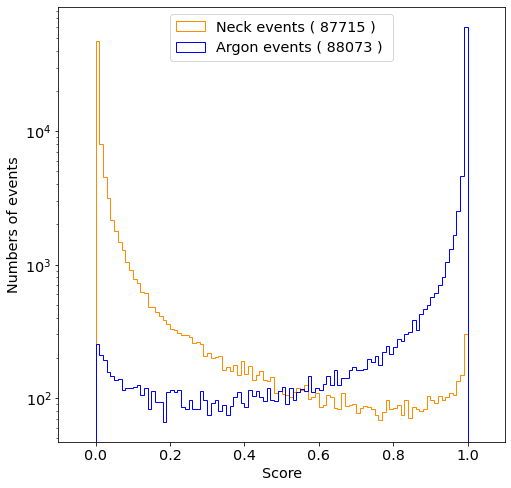

In [132]:
plt.figure(1,figsize=(8,8)) # figura numero 4
plt.style.use('seaborn-deep') 
#plt.hist(pred,100,histtype='step')
# seleccionamos los datos que cumplen que testY==0 es argo
print("test 0s number:  ",len(c0[0]))
plt.hist(r[c0],100,histtype='step',color='darkorange', label= "Neck events ( %d ) " % (len(c0[0]) ))
# selecionamos los de cuello testY==1
print("test 1s number:  ", len(c1[0]))
plt.hist(r[c1],100,histtype='step',color='blue', label= "Argon events ( %d ) " % (len(c1[0]) ))
plt.ylabel('Numbers of events')
plt.xlabel('Score')
plt.yscale("log")
title=" Probability of being Argon event (Test set)"
#plt.title(title)
plt.xlim(-0.1,1.1)
plt.legend( loc='upper center')

In [133]:
# Para pintar la curva ROC
def myroc(numal,true, pred):
	#calculamos tpr y fpr con sus errores para un numero numal de parametros de corte entre  0 y 1 equispaciados  
	alphas=np.arange(numal)
	TPR=np.empty(numal)
	FPR=np.empty(numal)
	erTPR=np.empty(numal)
	erFPR=np.empty(numal)
	#print(true.shape)
	for alpha in alphas: 
		pred_aprox=np.zeros(true.shape)	
		inter=np.where(pred>alpha/numal)
		pred_aprox[inter]=1
		tn, fp, fn, tp = confusion_matrix(true,pred_aprox).ravel()
		#TPR[alpha]=tp/(tp+fn)
		#erTPR[alpha]=sqrt(tp)/(tp+fn)
		#FPR[alpha]= fp/(fp+tn)
		#erFPR[alpha]=sqrt(fp)/(fp+tn)
	
	alphas=alphas/numal	
	return alphas , tp , fp , fn , tn 

In [134]:
def curvaroc(test,pred):
  # R= np.empty([testpos.shape[0]])
  numberneg=len(c0[0])
  numberpos=len(c1[0])
  print("Neck events  (test set):" , numberneg)
  print("Argon events (test set):" , numberpos)
  fpr, tpr, thresholds = roc_curve(test,pred)
  #print(roc_curve(testY,pred))

  precision, recall, alphas = precision_recall_curve(test,pred)
  pre_auc = auc(recall, precision)
  roc_auc = auc(fpr, tpr)	
  print("roc AUC :   ",roc_auc)
  print("Precision-recall auc:", pre_auc)

  ## 99.0%
  f= fpr[fpr>0.99]
  #print(f)
  btpr=tpr[fpr>0.01][0]
  bfpr=fpr[fpr>0.01][0]
  balf=thresholds[fpr>0.01][0]

  print("tpr" , btpr)
  print("fpr" , bfpr)
  print("1-fpr" , 1-bfpr)
  print("alpha" , balf)

  ## 99.9%
  btpr2=tpr[fpr>0.001][0]
  bfpr2=fpr[fpr>0.001][0]
  balf2=thresholds[fpr>0.001][0]

  print("tpr2" , btpr2)
  print("fpr2" , bfpr2)
  print("1-fpr2" , 1-bfpr2)
  print("alpha2" , balf2)

  # ## 90.0%
  # btpr3=tpr[fpr>0.1][0]
  # bfpr3=fpr[fpr>0.1][0]
  # balf3=thresholds[fpr>0.1][0]

  # print("tpr3" , btpr3)
  # print("fpr3" , bfpr3)
  # print("1-fpr3" , 1-bfpr3)
  # print("alpha3" , balf3)

  # ## 50.0%
  # btpr4=tpr[fpr>0.5][0]
  # bfpr4=fpr[fpr>0.5][0]
  # balf4=thresholds[fpr>0.5][0]

  # print("tpr4" , btpr4)
  # print("fpr4" , bfpr4)
  # print("1-fpr4" , 1-bfpr4)
  # print("alpha4" , balf4)

  p=precision[precision>0.99]
  bpre=p[0]
  brec=recall[precision>0.99][0]
  print('bpre',bpre)
  print('brec',brec)

  plt.figure(1,figsize=(8,8)) # figura 
  plt.style.use('seaborn-deep') 
  lw = 2
  plt.plot(1-fpr, tpr, color='blue',lw=2, label=' (area = %0.4f)' % (roc_auc))
  #plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
  #plt.plot([1-bfpr, 0], [1-bfpr, btpr], color='orange', lw=1, linestyle='--')
  #plt.plot([0, btpr], [1-bfpr, btpr], color='orange', lw=1, linestyle='--')

  # plt.plot([1-bfpr4, 1-bfpr4], [0, btVisualizationpr4], color='orange', lw=1, linestyle='--')
  # plt.plot([0, 1-bfpr4], [btpr4, btpr4], color='orange', lw=1, linestyle='--', label= "a= %0.3f (%0.3f , %0.3f)" % (balf4,1-bfpr4, btpr4))
  # plt.plot([1-bfpr3, 1-bfpr3], [0, btpr3], color='orange', lw=1, linestyle='--')
  # plt.plot([0, 1-bfpr3], [btpr3, btpr3], color='orange', lw=1, linestyle='--', label= "a= %0.3f (%0.3f , %0.3f)" % (balf3,1-bfpr3, btpr3))
  plt.plot([1-bfpr, 1-bfpr], [0, btpr], color='orange', lw=1, linestyle='--')
  plt.plot([0, 1-bfpr], [btpr, btpr], color='orange', lw=1, linestyle='--', label= "a= %0.3f (%0.3f , %0.3f)" % (balf,1-bfpr, btpr))
  plt.plot([1-bfpr2, 1-bfpr2], [0, btpr2], color='orange', lw=1, linestyle='--')
  plt.plot([0, 1-bfpr2], [btpr2, btpr2], color='orange', lw=1, linestyle='--', label= "a= %0.3f (%0.3f , %0.3f)" % (balf2,1-bfpr2, btpr2))

  plt.xlim([0.0, 1.0])
  plt.ylim([0.0, 1.0])
  plt.xlabel('Background Rejection Rate (1-FPr)')
  plt.ylabel('Acceptance (TPr)')
  plt.title('ROC curve')
  plt.legend(loc="lower left")

  # from google.colab import files
  # plt.savefig('ROC_curve_InceptionCNN1d_'+str(OurModel)+'_neckevents_1block_f1_64_f2_in_96_f2_out_128_f3_in_16_f3_out_32_f4_out_32'+'_Epochs_'+str(nepochs)+'_Batch_'+str(sizeofbatch)+'.eps')
  # files.download('ROC_curve_InceptionCNN1d_'+str(OurModel)+'_neckevents_1block_f1_64_f2_in_96_f2_out_128_f3_in_16_f3_out_32_f4_out_32'+'_Epochs_'+str(nepochs)+'_Batch_'+str(sizeofbatch)+'.eps') # uncomment for downloading

Neck events  (test set): 87715
Argon events (test set): 88073
roc AUC :    0.9851051230355676
Precision-recall auc: 0.9860690856755363
tpr 0.8134274976439999
fpr 0.010009690474833266
1-fpr 0.9899903095251668
alpha 0.94215393
tpr2 0.5253369364050277
fpr2 0.0010032491592088012
1-fpr2 0.9989967508407912
alpha2 0.9986066
bpre 0.9900082435543932
brec 0.7908780216411386


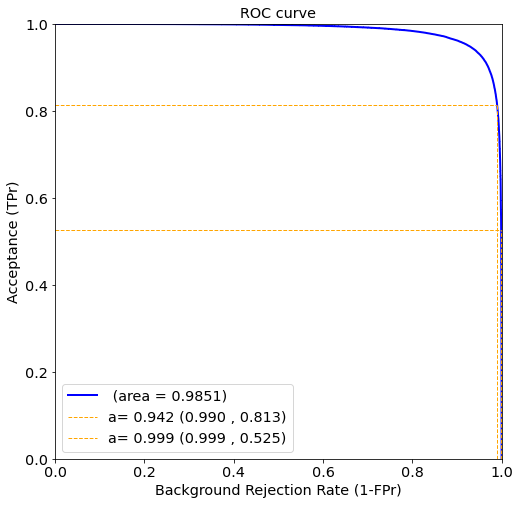

In [135]:
curvaroc(testYv,r)

Neck events  (test set): 87715
Argon events (test set): 88073
roc AUC :    0.9841994945817928
Precision-recall auc: 0.9843380903178351
tpr 0.8055022538121785
fpr 0.010009690474833266
1-fpr 0.9899903095251668
alpha 0.9454771
tpr2 0.4178579133219034
fpr2 0.0010032491592088012
1-fpr2 0.9989967508407912
alpha2 0.9995499
bpre 0.9900034620045006
brec 0.7792513028964609


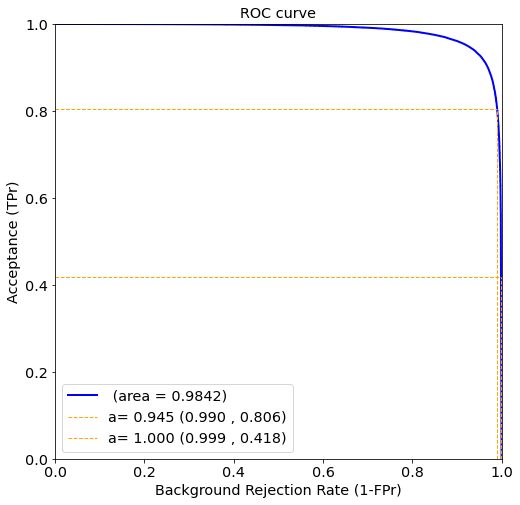

In [136]:
curvaroc(testYv,r1)

Neck events  (test set): 87715
Argon events (test set): 88073
roc AUC :    0.9809790170856405
Precision-recall auc: 0.9781798104711212
tpr 0.7714168928048324
fpr 0.010009690474833266
1-fpr 0.9899903095251668
alpha 0.9601772
tpr2 0.05881484677483451
fpr2 0.0010032491592088012
1-fpr2 0.9989967508407912
alpha2 0.9999981
bpre 0.9900035591043437
brec 0.7264087745393026


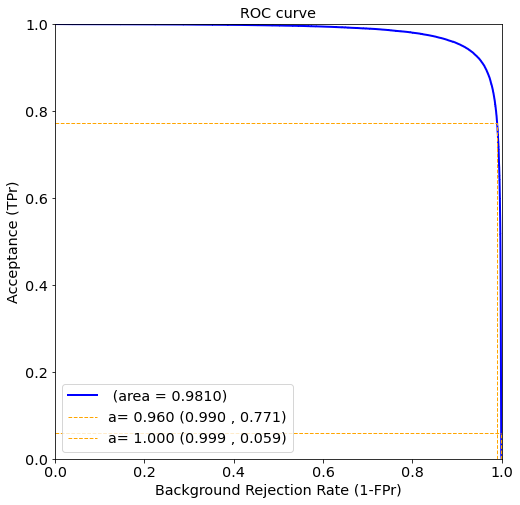

In [137]:
curvaroc(testYv,r5)

Neck events  (test set): 87715
Argon events (test set): 88073
roc AUC :    0.9767382101092794
Precision-recall auc: 0.9704566022479774
tpr 0.7180293620065173
fpr 0.010009690474833266
1-fpr 0.9899903095251668
alpha 0.97713053
tpr2 0.008572434230694991
fpr2 0.0015960782078321839
1-fpr2 0.9984039217921679
alpha2 1.0
bpre 0.9900163231218919
brec 0.5922359860570209


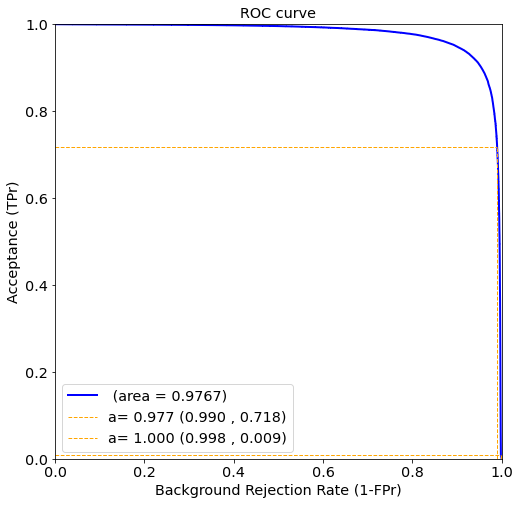

In [138]:
curvaroc(testYv,r10)

## Modelo destilado

In [139]:
p,p1,p5,p10=predictions(model)
pd,pd1,pd5,pd10=predictions(modeld)

test 0s number:   87715
test 1s number:   88073


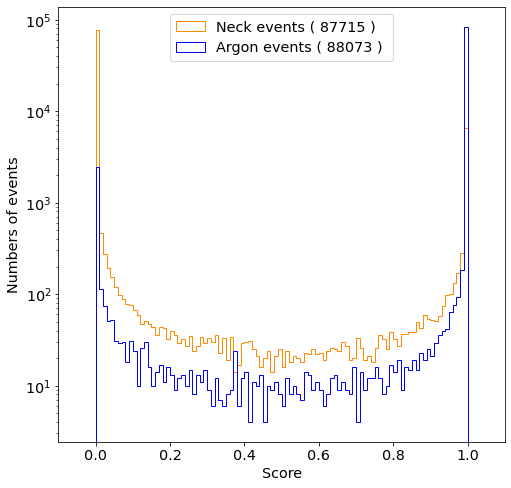

In [140]:
plt.figure(1,figsize=(8,8)) # figura numero 4
plt.style.use('seaborn-deep') 
#plt.hist(pred,100,histtype='step')
# seleccionamos los datos que cumplen que testY==0 es argo
print("test 0s number:  ",len(c0[0]))
plt.hist(pd[c0],100,histtype='step',color='darkorange', label= "Neck events ( %d ) " % (len(c0[0]) ))
# selecionamos los de cuello testY==1
print("test 1s number:  ", len(c1[0]))
plt.hist(pd[c1],100,histtype='step',color='blue', label= "Argon events ( %d ) " % (len(c1[0]) ))
plt.ylabel('Numbers of events')
plt.xlabel('Score')
plt.yscale("log")
title=" Probability of being Argon event (Test set)"
#plt.title(title)
plt.xlim(-0.1,1.1)
plt.legend( loc='upper center')

# from google.colab import files
# plt.savefig('scores_InceptionCNN1d_'+str(OurModel)+'_neckevents_1block_f1_64_f2_in_96_f2_out_128_f3_in_16_f3_out_32_f4_out_32'+'_Epochs_'+str(nepochs)+'_Batch_'+str(sizeofbatch)+'.eps')
# files.download('scores_InceptionCNN1d_'+str(OurModel)+'_neckevents_1block_f1_64_f2_in_96_f2_out_128_f3_in_16_f3_out_32_f4_out_32'+'_Epochs_'+str(nepochs)+'_Batch_'+str(sizeofbatch)+'.eps')  # uncomment for downloading

Neck events  (test set): 87715
Argon events (test set): 88073
roc AUC :    0.973184641953352
Precision-recall auc: 0.9740226408281609
tpr 0.9016384135887275
fpr 0.03297041555036197
1-fpr 0.967029584449638
alpha 1.0
tpr2 0.9016384135887275
fpr2 0.03297041555036197
1-fpr2 0.967029584449638
alpha2 1.0
bpre 1.0
brec 0.0


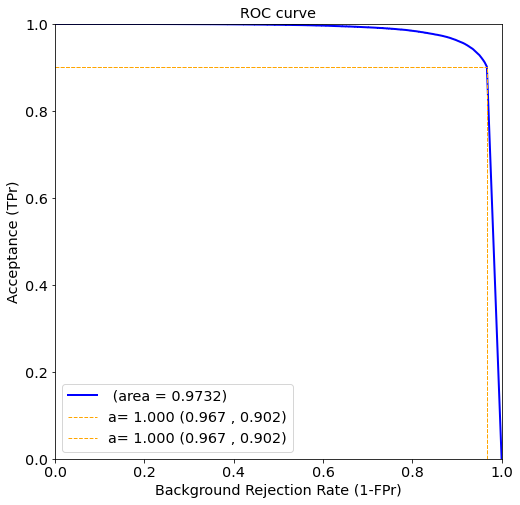

In [141]:
curvaroc(testYv,pd)

Neck events  (test set): 87715
Argon events (test set): 88073
roc AUC :    0.9726132435291597
Precision-recall auc: 0.9735214442840493
tpr 0.8984592326819797
fpr 0.03314142392977256
1-fpr 0.9668585760702274
alpha 1.0
tpr2 0.8984592326819797
fpr2 0.03314142392977256
1-fpr2 0.9668585760702274
alpha2 1.0
bpre 1.0
brec 0.0


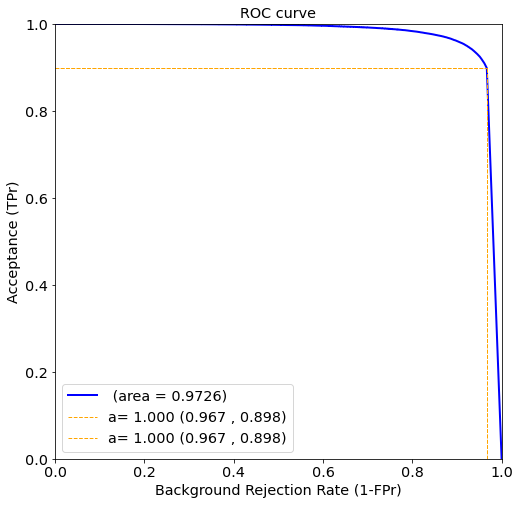

In [142]:
curvaroc(testYv,pd1)

Neck events  (test set): 87715
Argon events (test set): 88073
roc AUC :    0.9696383907081314
Precision-recall auc: 0.970815281437707
tpr 0.8894894008379413
fpr 0.0355925440346577
1-fpr 0.9644074559653423
alpha 1.0
tpr2 0.8894894008379413
fpr2 0.0355925440346577
1-fpr2 0.9644074559653423
alpha2 1.0
bpre 1.0
brec 0.0


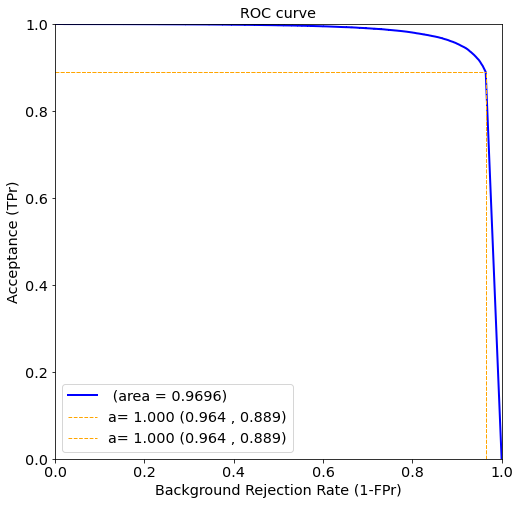

In [143]:
curvaroc(testYv,pd5)

Neck events  (test set): 87715
Argon events (test set): 88073
roc AUC :    0.9655825414304885
Precision-recall auc: 0.9670636758862762
tpr 0.8798269617249327
fpr 0.03958273955423816
1-fpr 0.9604172604457618
alpha 1.0
tpr2 0.8798269617249327
fpr2 0.03958273955423816
1-fpr2 0.9604172604457618
alpha2 1.0
bpre 1.0
brec 0.0


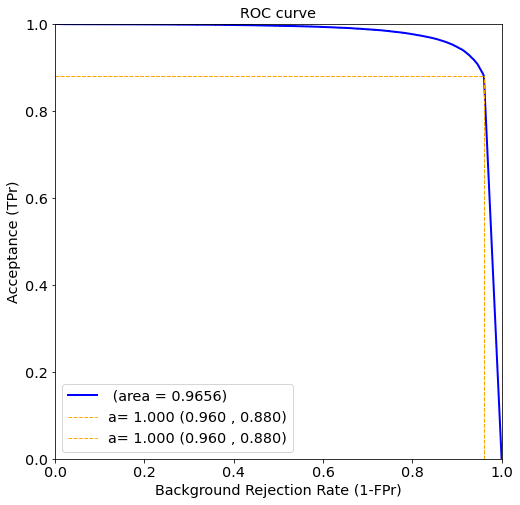

In [144]:
curvaroc(testYv,pd10)